<a href="https://colab.research.google.com/github/relmarrakchy/phishing-URL-detection/blob/master/phishing_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, classification_report)

In [88]:
from google.colab import drive
drive.mount('/content/drive')

dataset = pd.read_csv("/content/drive/MyDrive/datasets/Phising_Detection_Dataset.csv")
dataset.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Unnamed: 0,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsInHostname,PathLevel,PathLength,NumNumericChars,Phising
0,0,3,72,0,0,0,0,5,44,0,1.0
1,1,3,144,0,0,0,0,3,16,41,1.0
2,2,3,58,0,0,0,0,2,24,0,1.0
3,3,3,79,1,0,0,0,6,50,0,1.0
4,4,3,46,0,0,0,0,4,29,2,1.0


In [89]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 662591 entries, 0 to 662590
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Unnamed: 0       662591 non-null  int64  
 1   NumDots          662591 non-null  int64  
 2   UrlLength        662591 non-null  int64  
 3   NumDash          662591 non-null  int64  
 4   AtSymbol         662591 non-null  int64  
 5   IpAddress        662591 non-null  int64  
 6   HttpsInHostname  662591 non-null  int64  
 7   PathLevel        662591 non-null  int64  
 8   PathLength       662591 non-null  int64  
 9   NumNumericChars  662591 non-null  int64  
 10  Phising          630071 non-null  float64
dtypes: float64(1), int64(10)
memory usage: 55.6 MB


In [90]:
dataset.drop(columns=["Unnamed: 0"], inplace=True)

dataset.rename(columns={"Phising": "Phishing"})

,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsInHostname,PathLevel,PathLength,NumNumericChars,Phishing
0,3,72,0,0,0,0,5,44,0,1.0
1,3,144,0,0,0,0,3,16,41,1.0
2,3,58,0,0,0,0,2,24,0,1.0
3,3,79,1,0,0,0,6,50,0,1.0
4,3,46,0,0,0,0,4,29,2,1.0
...,...,...,...,...,...,...,...,...,...,...
662586,3,39,0,0,0,0,4,39,1,1.0
662587,2,44,2,0,0,0,4,44,1,1.0
662588,2,42,0,0,0,0,4,42,1,1.0
662589,2,45,0,0,0,0,3,45,0,1.0


In [91]:
dataset["Phising"].value_counts()

0.0    530060
1.0    100011
Name: Phising, dtype: int64

In [92]:
dataset = dataset.dropna(subset=['Phising'])

In [93]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 630071 entries, 0 to 662590
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   NumDots          630071 non-null  int64  
 1   UrlLength        630071 non-null  int64  
 2   NumDash          630071 non-null  int64  
 3   AtSymbol         630071 non-null  int64  
 4   IpAddress        630071 non-null  int64  
 5   HttpsInHostname  630071 non-null  int64  
 6   PathLevel        630071 non-null  int64  
 7   PathLength       630071 non-null  int64  
 8   NumNumericChars  630071 non-null  int64  
 9   Phising          630071 non-null  float64
dtypes: float64(1), int64(9)
memory usage: 52.9 MB


In [94]:
dataset.head()

,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsInHostname,PathLevel,PathLength,NumNumericChars,Phising
0,3,72,0,0,0,0,5,44,0,1.0
1,3,144,0,0,0,0,3,16,41,1.0
2,3,58,0,0,0,0,2,24,0,1.0
3,3,79,1,0,0,0,6,50,0,1.0
4,3,46,0,0,0,0,4,29,2,1.0


In [95]:
dataset["IpAddress"].value_counts()

0    629465
1       606
Name: IpAddress, dtype: int64

In [96]:
dataset.drop(columns=['IpAddress'], inplace=True)

dataset.head()

,NumDots,UrlLength,NumDash,AtSymbol,HttpsInHostname,PathLevel,PathLength,NumNumericChars,Phising
0,3,72,0,0,0,5,44,0,1.0
1,3,144,0,0,0,3,16,41,1.0
2,3,58,0,0,0,2,24,0,1.0
3,3,79,1,0,0,6,50,0,1.0
4,3,46,0,0,0,4,29,2,1.0


In [97]:
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [98]:
model = Sequential([
    Dense(18, activation='relu', input_shape=(8,)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 18)                162       
                                                                 
 dense_28 (Dense)            (None, 8)                 152       
                                                                 
 dense_29 (Dense)            (None, 1)                 9         
                                                                 
Total params: 323 (1.26 KB)
Trainable params: 323 (1.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [99]:
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


15752/15752 [==============================] - 30s 2ms/step - loss: 0.3927 - accuracy: 0.8382
Epoch 2/20
15752/15752 [==============================] - 29s 2ms/step - loss: 0.3307 - accuracy: 0.8580
Epoch 3/20
15752/15752 [==============================] - 30s 2ms/step - loss: 0.3234 - accuracy: 0.8592
Epoch 4/20
15752/15752 [==============================] - 29s 2ms/step - loss: 0.3187 - accuracy: 0.8605
Epoch 5/20
15752/15752 [==============================] - 30s 2ms/step - loss: 0.3151 - accuracy: 0.8616
Epoch 6/20
15752/15752 [==============================] - 29s 2ms/step - loss: 0.3126 - accuracy: 0.8626
Epoch 7/20
15752/15752 [==============================] - 33s 2ms/step - loss: 0.3104 - accuracy: 0.8632
Epoch 8/20
15752/15752 [==============================] - 28s 2ms/step - loss: 0.3085 - accuracy: 0.8638
Epoch 9/20
15752/15752 [==============================] - 28s 2ms/step - loss: 0.3068 - accuracy: 0.8644
Epoch 10/20
15752/15752 [==============================] - 29s 2ms

In [100]:
loss, accuracy = model.evaluate(X_test, y_test)
accuracy

3938/3938 [==============================] - 5s 1ms/step - loss: 0.2989 - accuracy: 0.8723


0.872300922870636

3938/3938 [==============================] - 5s 1ms/step


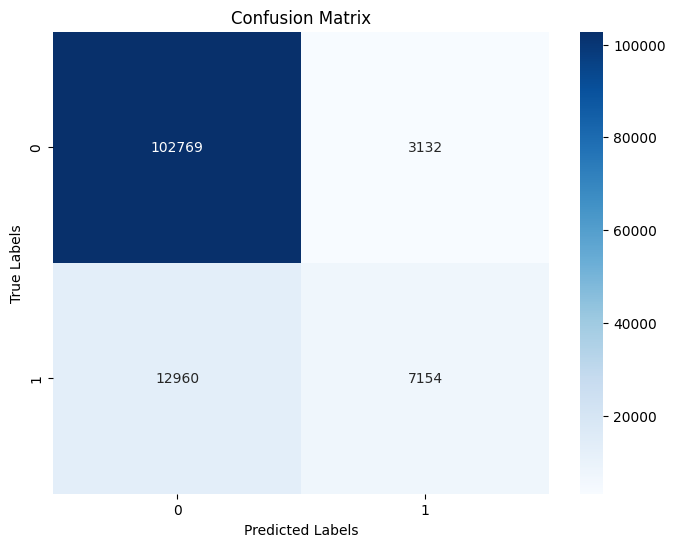

In [110]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [108]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93    105901
         1.0       0.70      0.36      0.47     20114

    accuracy                           0.87    126015
   macro avg       0.79      0.66      0.70    126015
weighted avg       0.86      0.87      0.85    126015

